<a href="https://colab.research.google.com/github/ddcreating/RL_code/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


Training 1-step SARSA for comparison...


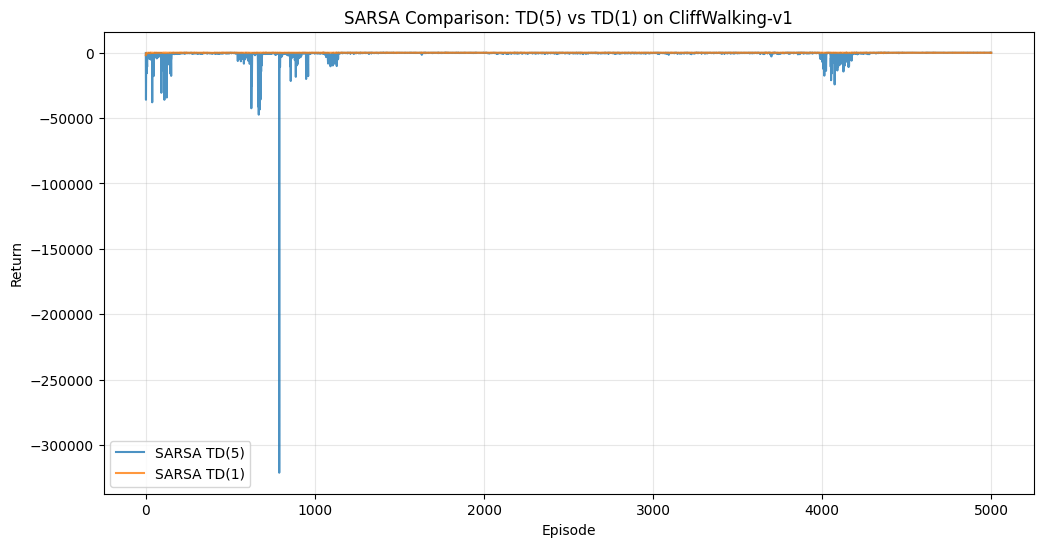

TD(5) - Average return over last 100 episodes: -22.98
TD(1) - Average return over last 100 episodes: -22.66
Final Q-table shape: (48, 4)

COMPARISON: TD(5) vs TD(1) SARSA
TD(5) convergence episode: 259
TD(1) convergence episode: 305
Final performance - TD(5): -22.98
Final performance - TD(1): -22.66

Analysis:
✓ TD(5) converges faster than TD(1)
✓ TD(1) achieves better final performance

Learned Policy (arrows show preferred actions):
C = Cliff, G = Goal
→ → → → → → → → → → → ↓ 
↑ → ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ← ↓ 
↑ ↑ ← ↑ ↑ ↑ ↑ ↑ ↑ ↑ → ↓ 
S C C C C C C C C C C G 

Learned Policy (arrows show preferred actions):
C = Cliff, G = Goal
→ → → → → → → → → → → ↓ 
↑ → ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ← ↓ 
↑ ↑ ← ↑ ↑ ↑ ↑ ↑ ↑ ↑ → ↓ 
S C C C C C C C C C C G 


In [7]:
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1")

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.1         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 5000

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns = []

for ep in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state)

    # Buffers to store the trajectory
    states = deque()
    actions = deque()
    rewards = deque()

    T = float("inf")
    t = 0
    done = False

    while True:
        if t < T:
            # Take action in environment
            # next_state, reward, terminated, truncated, _ = env.step(action)
            # done = terminated or truncated

            # # Store experience
            # states.append(state)
            # actions.append(action)
            # rewards.append(reward)
            # Store experience
            states.append(state)
            actions.append(action)
            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            rewards.append(reward)

            if done:
                T = t + 1
            else:
                # SARSA: choose next action for current policy
                next_action = epsilon_greedy(next_state)
                state = next_state
                action = next_action

        # Update Q-value for state-action pair from n steps ago
        tau = t - n_step + 1
        if tau >= 0:
            # Compute n-step return
            G = 0.0
            G = sum(gamma**(i-tau) * rewards[i] for i in range(tau, min(tau+n_step, T)))
            # for i in range(tau, min(tau + n_step, T)):
            #     G += (gamma ** (i - tau)) * rewards[i]

            # Add bootstrap value if episode hasn't ended and we have enough states
            if tau + n_step < T:
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # Update Q-value
            s_tau = states[tau]
            a_tau = actions[tau]
            Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

        # Check if we're done updating
        if tau == T - 1:
            break

        t += 1

    # Record episode return
    episode_returns.append(sum(rewards))

# Store TD(5) results
td5_returns = episode_returns.copy()

# Now implement standard 1-step SARSA for comparison
print("Training 1-step SARSA for comparison...")
Q_1step = np.zeros((n_states, n_actions))
episode_returns_1step = []

def epsilon_greedy_1step(state):
    """Choose an action using epsilon-greedy policy for 1-step SARSA."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q_1step[state])

for ep in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy_1step(state)
    episode_reward = 0

    while True:
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        if done:
            # Terminal state update
            Q_1step[state, action] += alpha * (reward - Q_1step[state, action])
            break
        else:
            # Choose next action (SARSA)
            next_action = epsilon_greedy_1step(next_state)

            # Update Q-value using 1-step TD
            Q_1step[state, action] += alpha * (reward + gamma * Q_1step[next_state, next_action] - Q_1step[state, action])

            # Move to next state-action pair
            state = next_state
            action = next_action

    episode_returns_1step.append(episode_reward)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(td5_returns, label='SARSA TD(5)', alpha=0.8)
plt.plot(episode_returns_1step, label='SARSA TD(1)', alpha=0.8)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA Comparison: TD(5) vs TD(1) on CliffWalking-v1")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print comparison results
print(f"TD(5) - Average return over last 100 episodes: {np.mean(td5_returns[-100:]):.2f}")
print(f"TD(1) - Average return over last 100 episodes: {np.mean(episode_returns_1step[-100:]):.2f}")
print(f"Final Q-table shape: {Q.shape}")

# Optional: Display learned policy for visualization
# def display_policy()
def display_policy():
    """Display the learned policy as arrows"""
    action_symbols = ['↑', '→', '↓', '←']
    policy_grid = np.zeros((4, 12), dtype=str)

    for state in range(n_states):
        row, col = divmod(state, 12)
        best_action = np.argmax(Q[state])
        policy_grid[row, col] = action_symbols[best_action]

    print("\nLearned Policy (arrows show preferred actions):")
    print("C = Cliff, G = Goal")
    for row in range(4):
        row_str = ""
        for col in range(12):
            if row == 3 and col == 0:
                row_str += "S "  # Start
            elif row == 3 and col == 11:
                row_str += "G "  # Goal
            elif row == 3 and 1 <= col <= 10:
                row_str += "C "  # Cliff
            else:
                row_str += policy_grid[row, col] + " "
        print(row_str)


# Comparison Analysis
print("\n" + "="*60)
print("COMPARISON: TD(5) vs TD(1) SARSA")
print("="*60)

# Calculate convergence metrics
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

td5_smooth = moving_average(td5_returns)
td1_smooth = moving_average(episode_returns_1step)

# Find convergence point (when moving average stabilizes within 5% for 200 episodes)
def find_convergence(smooth_data, threshold=0.05, window=200):
    for i in range(len(smooth_data) - window):
        segment = smooth_data[i:i+window]
        if np.std(segment) / abs(np.mean(segment)) < threshold:
            return i + 100  # Add back the moving average offset
    return len(smooth_data)

td5_convergence = find_convergence(td5_smooth)
td1_convergence = find_convergence(td1_smooth)

print(f"TD(5) convergence episode: {td5_convergence}")
print(f"TD(1) convergence episode: {td1_convergence}")
print(f"Final performance - TD(5): {np.mean(td5_returns[-100:]):.2f}")
print(f"Final performance - TD(1): {np.mean(episode_returns_1step[-100:]):.2f}")

print("\nAnalysis:")
if td5_convergence < td1_convergence:
    print("✓ TD(5) converges faster than TD(1)")
else:
    print("✓ TD(1) converges faster than TD(5)")

if np.mean(td5_returns[-100:]) > np.mean(episode_returns_1step[-100:]):
    print("✓ TD(5) achieves better final performance")
else:
    print("✓ TD(1) achieves better final performance")
    """Display the learned policy as arrows"""
    action_symbols = ['↑', '→', '↓', '←']
    policy_grid = np.zeros((4, 12), dtype=str)

    for state in range(n_states):
        row, col = divmod(state, 12)
        best_action = np.argmax(Q[state])
        policy_grid[row, col] = action_symbols[best_action]

    print("\nLearned Policy (arrows show preferred actions):")
    print("C = Cliff, G = Goal")
    for row in range(4):
        row_str = ""
        for col in range(12):
            if row == 3 and col == 0:
                row_str += "S "  # Start
            elif row == 3 and col == 11:
                row_str += "G "  # Goal
            elif row == 3 and 1 <= col <= 10:
                row_str += "C "  # Cliff
            else:
                row_str += policy_grid[row, col] + " "
        print(row_str)

display_policy()

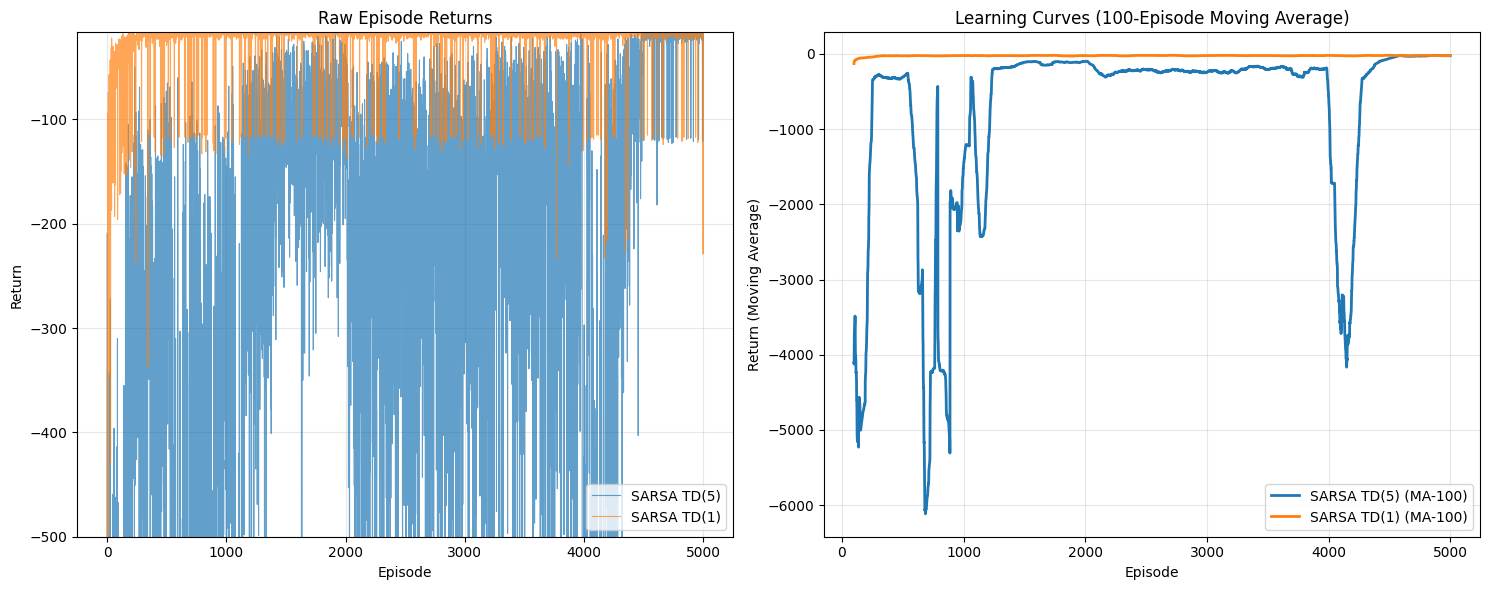

TD(5) Statistics:
  Final 100 episodes average: -22.98
  Best episode return: -17.00
  Worst episode return: -321227.00

TD(1) Statistics:
  Final 100 episodes average: -22.66
  Best episode return: -15.00
  Worst episode return: -1864.00


In [8]:
# Improved plotting with better visualization
def plot_comparison(td5_returns, td1_returns, window=100):
    """Plot comparison with moving averages and better y-axis scaling"""

    # Calculate moving averages for smoother curves
    def moving_average(data, window):
        if len(data) < window:
            return data
        return np.convolve(data, np.ones(window)/window, mode='valid')

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Raw episode returns (clipped for better visualization)
    ax1.plot(td5_returns, label='SARSA TD(5)', alpha=0.7, linewidth=0.8)
    ax1.plot(td1_returns, label='SARSA TD(1)', alpha=0.7, linewidth=0.8)
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Return")
    ax1.set_title("Raw Episode Returns")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Clip y-axis to reasonable range for better visualization
    y_min = max(min(min(td5_returns), min(td1_returns)) * 1.1, -500)
    y_max = max(max(td5_returns), max(td1_returns)) * 1.1
    ax1.set_ylim(y_min, y_max)

    # Plot 2: Moving averages
    td5_smooth = moving_average(td5_returns, window)
    td1_smooth = moving_average(td1_returns, window)

    episodes_smooth = range(window-1, len(td5_returns))
    ax2.plot(episodes_smooth[:len(td5_smooth)], td5_smooth,
             label=f'SARSA TD(5) (MA-{window})', linewidth=2)
    ax2.plot(episodes_smooth[:len(td1_smooth)], td1_smooth,
             label=f'SARSA TD(1) (MA-{window})', linewidth=2)
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Return (Moving Average)")
    ax2.set_title(f"Learning Curves ({window}-Episode Moving Average)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"TD(5) Statistics:")
    print(f"  Final 100 episodes average: {np.mean(td5_returns[-100:]):.2f}")
    print(f"  Best episode return: {max(td5_returns):.2f}")
    print(f"  Worst episode return: {min(td5_returns):.2f}")

    print(f"\nTD(1) Statistics:")
    print(f"  Final 100 episodes average: {np.mean(td1_returns[-100:]):.2f}")
    print(f"  Best episode return: {max(td1_returns):.2f}")
    print(f"  Worst episode return: {min(td1_returns):.2f}")

# Call the function with your data
plot_comparison(td5_returns, episode_returns_1step)

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
